In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
CHANNELS = 3
EPOCHS = 20

In [3]:
from google.colab import drive
import tensorflow as tf

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Specify the path to your dataset
dataset_path = '/content/drive/MyDrive/PROJECT_IMAGES'

# Define your image size and batch size
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

# Create the image dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    seed=123,
    shuffle=True,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

Mounted at /content/drive
Found 2080 files belonging to 32 classes.


In [4]:
class_names = dataset.class_names
class_names

['Bird Not Detected',
 'Black Hooded Oriole',
 'Black rumped flameback woodpecker',
 'Brown headed barbet',
 "Can't identify the Bird",
 'Cattle egret',
 'Common Tailor Bird',
 'Crow',
 'Duck',
 'Greater Coucal',
 'Greater Flamingos',
 'Greater Hornbill',
 'Greater racket-tailed drongo',
 'Hen',
 'Jungle Babbler',
 'Kingfisher',
 'Knob billed duck',
 'Laughing Gull',
 'Little Cormorant',
 "Loten's Sunbird",
 'Love Birds',
 'Mottled Wood Owl',
 'Myna',
 'Oriental Magpie Robin',
 'Peacock',
 'Purple Heron',
 'Rain Quail',
 'Red whiskered Bulbul',
 'Rock Pigeon',
 'Rose ringed Parakeet',
 'Rufous treepie',
 'Sri Lanka Frogmouth']

In [5]:
len(dataset)

65

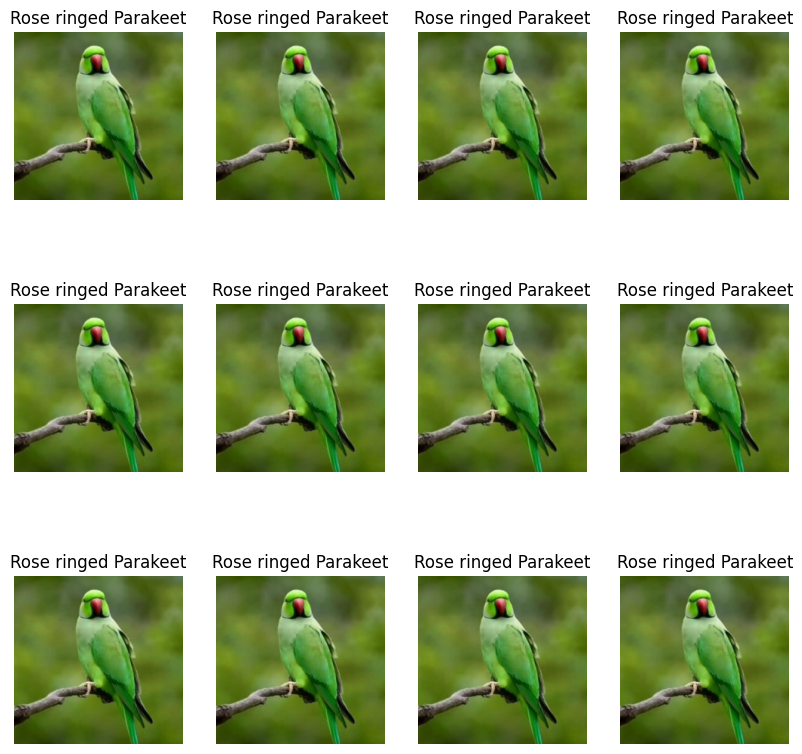

In [6]:

plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])
    plt.axis("off")

In [7]:
len(dataset)

65

In [8]:
train_size = 0.8
len(dataset)*train_size

52.0

In [9]:
train_ds = dataset.take(80)
len(train_ds)

65

In [10]:
test_ds = dataset.skip(80)
len(test_ds)

0

In [11]:
val_size = 0.1
len(dataset)*val_size

6.5

In [12]:
val_ds = test_ds.take(10)
len(val_ds)

0

In [13]:
test_ds = test_ds.skip(10)
len(test_ds)

0

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):

    ds_size = len(ds)
    if shuffle:
      ds = ds.shuffle(shuffle_size, seed = 12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)


    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)

52

In [17]:
len(val_ds)

6

In [18]:
len(test_ds)

7

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
resize_and_rescale = tf.keras.Sequential([
    layers.Lambda(lambda x: tf.image.resize_with_pad(x, IMAGE_SIZE[0], IMAGE_SIZE[1])),
    layers.Lambda(lambda x: x * (1./255.0)),  # Rescale
])

In [21]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [22]:
input_shape = (1, IMAGE_SIZE[0], IMAGE_SIZE[1], CHANNELS)
n_classes = 32

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(38, activation='softmax'),
])



# Display model summary
model.build(input_shape=input_shape)

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (1, 224, 224, 3)          0         
                                                                 
 conv2d (Conv2D)             (1, 222, 222, 32)         896       
                                                                 
 max_pooling2d (MaxPooling2  (1, 111, 111, 32)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (1, 109, 109, 64)         18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (1, 54, 54, 64)           0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (1, 52, 52, 64)          

In [24]:
from tensorflow.keras.utils import to_categorical

In [25]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [26]:
# Assuming train_ds has elements in the form (images, labels)
train_labels = [label for _, label in train_ds]
val_labels = [label for _, label in val_ds]

# Flatten nested labels
train_labels_flat = [item for sublist in train_labels for item in sublist]
val_labels_flat = [item for sublist in val_labels for item in sublist]

In [27]:
train_labels_one_hot = to_categorical(train_labels_flat, num_classes=n_classes)
val_labels_one_hot = to_categorical(val_labels_flat, num_classes=n_classes)

In [28]:
print(f"Train labels shape: {train_labels_one_hot.shape}")
print(f"Validation labels shape: {val_labels_one_hot.shape}")

Train labels shape: (1664, 32)
Validation labels shape: (192, 32)


In [29]:
model.output_shape

(1, 38)

In [30]:
print(f"Type of train_labels: {type(train_labels)}")
print(f"Type of val_labels: {type(val_labels)}")

Type of train_labels: <class 'list'>
Type of val_labels: <class 'list'>


In [31]:
train_labels_one_hot.shape
val_labels_one_hot.shape

(192, 32)

In [32]:
model.output_shape == train_labels_one_hot.shape
model.output_shape == val_labels_one_hot.shape

False

In [33]:
# Remove the to_categorical calls
train_labels_one_hot = train_labels_flat
val_labels_one_hot = val_labels_flat

In [34]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")

In [35]:
# Remove the to_categorical calls
train_labels_one_hot = train_labels_flat
val_labels_one_hot = val_labels_flat

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [36]:
# Train the model
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=20,
)

Epoch 1/20
52/52 [==============================] - 171s 3s/step - loss: 3.5729 - accuracy: 0.0367 - val_loss: 3.3991 - val_accuracy: 0.0521
Epoch 2/20
52/52 [==============================] - 165s 3s/step - loss: 3.3346 - accuracy: 0.0631 - val_loss: 3.2559 - val_accuracy: 0.0521
Epoch 3/20
52/52 [==============================] - 169s 3s/step - loss: 3.1649 - accuracy: 0.1010 - val_loss: 3.0257 - val_accuracy: 0.1406
Epoch 4/20
52/52 [==============================] - 170s 3s/step - loss: 2.9735 - accuracy: 0.1599 - val_loss: 2.8954 - val_accuracy: 0.1719
Epoch 5/20
52/52 [==============================] - 163s 3s/step - loss: 2.7828 - accuracy: 0.1911 - val_loss: 2.5365 - val_accuracy: 0.2656
Epoch 6/20
52/52 [==============================] - 158s 3s/step - loss: 2.5632 - accuracy: 0.2596 - val_loss: 2.4171 - val_accuracy: 0.2865
Epoch 7/20
52/52 [==============================] - 162s 3s/step - loss: 2.3693 - accuracy: 0.2975 - val_loss: 2.2379 - val_accuracy: 0.2969
Epoch 8/20
52

In [37]:
score = model.evaluate(test_ds)
scores = score

print(scores)

7/7 [==============================] - 15s 715ms/step - loss: 0.8909 - accuracy: 0.8080
[0.8909393548965454, 0.8080357313156128]


In [38]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 52}

In [39]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [40]:
type(history.history['loss'])

list

In [41]:
len(history.history['loss'])

20

In [42]:
history.history['loss'][:5] # show loss for first 5 epochs

[3.5729048252105713,
 3.3345656394958496,
 3.164889335632324,
 2.973532199859619,
 2.7827556133270264]

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

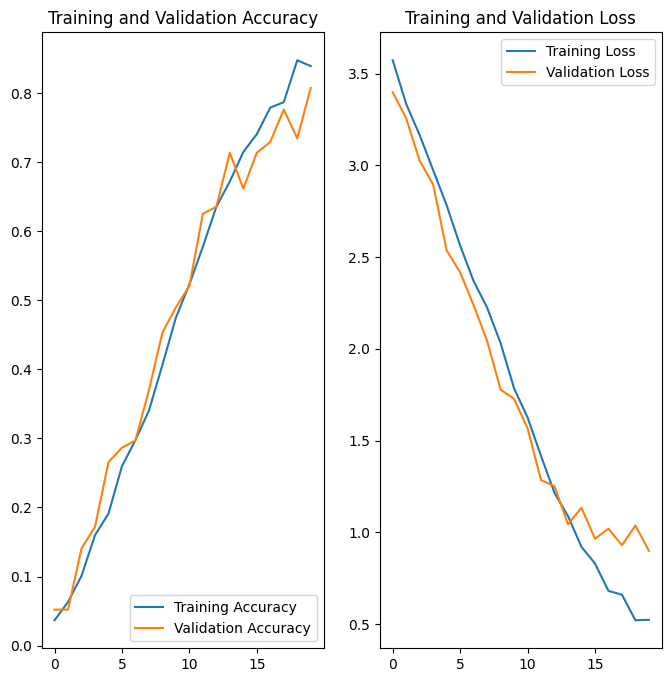

In [44]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Greater Hornbill
1/1 [==============================] - 2s 2s/step
predicted label: Greater Hornbill


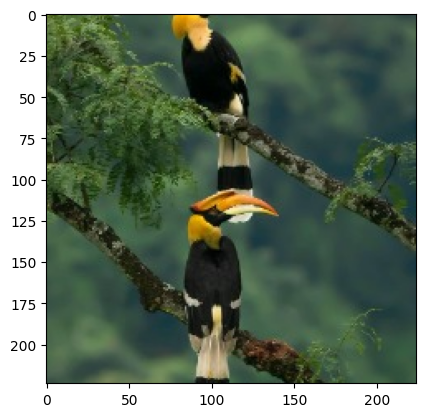

In [45]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [50]:
def predict(model, img):
    # Convert the image to a NumPy array
    img_array = tf.keras.preprocessing.image.img_to_array(img)

    # Expand the dimensions to match the model's expected input shape
    img_array = tf.expand_dims(img_array, 0)

    # Make predictions
    predictions = model.predict(img_array)

    # Get the predicted class index
    predicted_class_index = np.argmax(predictions[0])

    # Get the class name corresponding to the predicted index
    predicted_class = class_names[predicted_class_index]

    # Get the confidence (probability) for the predicted class
    confidence = round(100 * np.max(predictions[0]), 2)

    return predicted_class, confidence

1/1 [==============================] - 0s 45ms/step


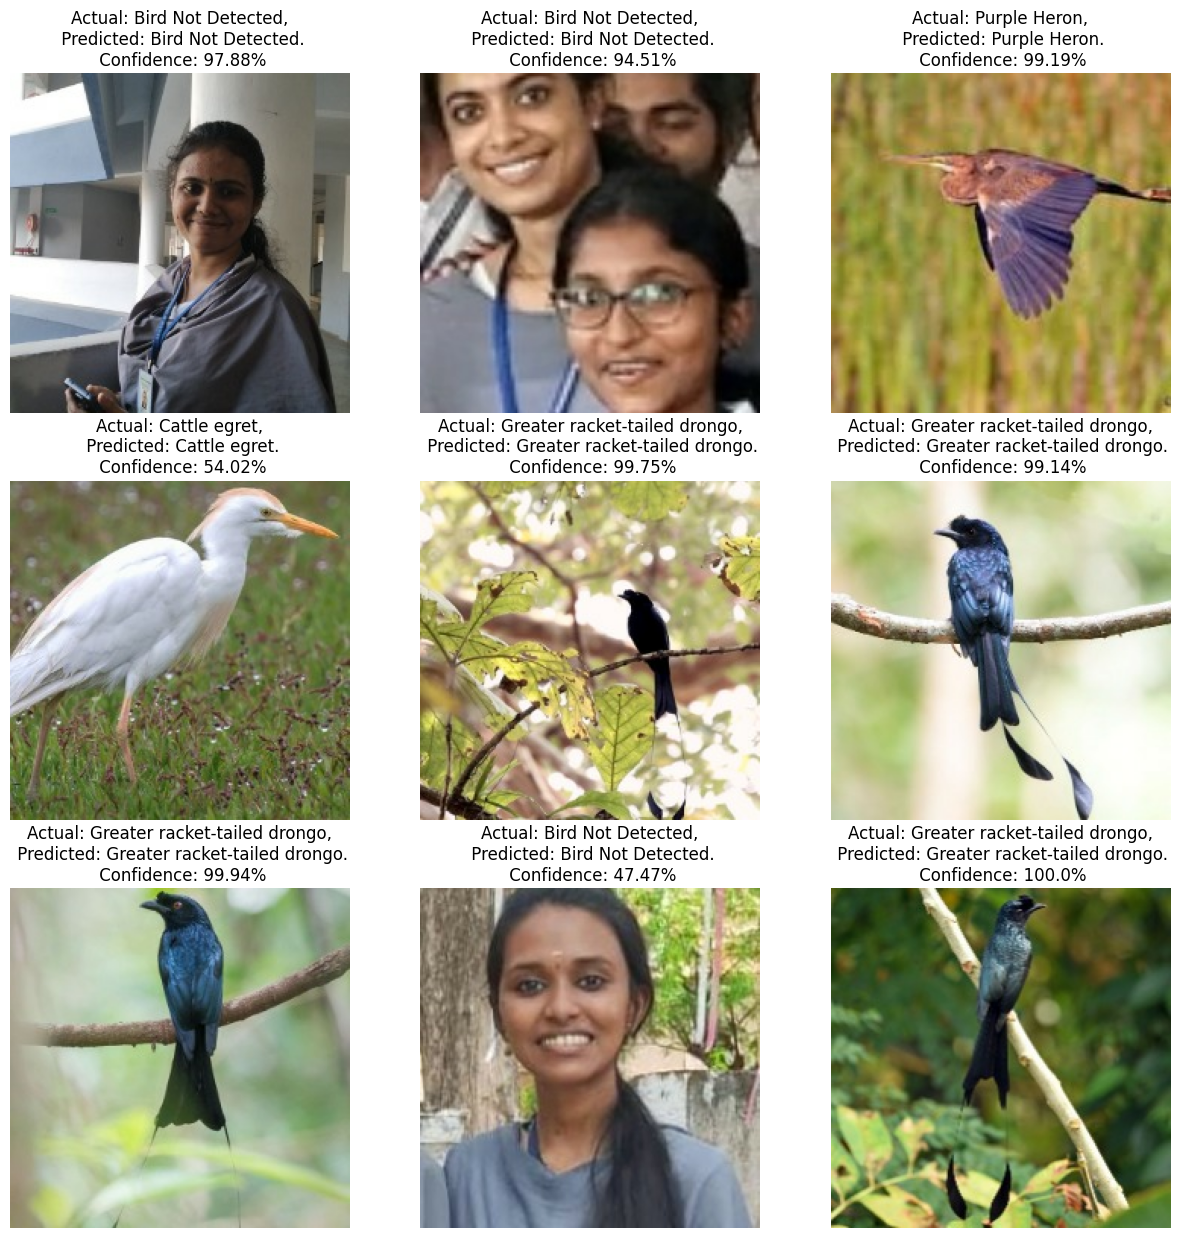

In [54]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")


In [55]:
import os
print(os.getcwd())

/content


In [56]:
import os

# Create the 'models' directory if it doesn't exist
models_dir = '/content/models'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

# List existing models in the 'models' directory
existing_models = [f for f in os.listdir(models_dir) if f.endswith('.h5')]

# Find the highest model version and increment it
model_version = max([int(model[:-3]) for model in existing_models] + [0]) + 1

# Save the model with the new version
model.save(f"{models_dir}/model_{model_version}.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [57]:
import tensorflow as tf

# Load the saved Keras model
model_path = '/content/models/model_1.h5'  # Update with the path to your saved model
keras_model = tf.keras.models.load_model(model_path)



In [58]:

# Convert the Keras model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
tflite_model = converter.convert()


In [59]:
tflite_model_path = '/content/models/model_latest.tflite'  # Update with the desired path to save the .tflite file
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print("TensorFlow Lite model saved successfully!")

TensorFlow Lite model saved successfully!


In [60]:
import numpy as np
import tensorflow as tf

# Load the TensorFlow Lite model
interpreter = tf.lite.Interpreter(model_path="/content/models/model_latest.tflite")
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Prepare test data (assuming test_data contains input images)
# preprocess_test_data(test_data)

# Iterate through the test data
for image_batch, labels_batch in test_ds.take(2):  # assuming test_data is your TensorFlow dataset
    # Iterate through each image in the batch
    for image, label in zip(image_batch, labels_batch):
        # Convert the image to the input format expected by the TFLite model
        input_data = image.numpy().astype(np.float32)
        input_data = np.expand_dims(input_data, axis=0)

        # Set the input tensor
        interpreter.set_tensor(input_details[0]['index'], input_data)

        # Run inference
        interpreter.invoke()

        # Get the output tensor
        output_data = interpreter.get_tensor(output_details[0]['index'])

        # Process the output (assuming output is classification probabilities)
        predicted_label_index = np.argmax(output_data)
        predicted_label = class_names[predicted_label_index]

        # Print the predicted label and actual label
        print("Predicted label:", predicted_label)
        print("Actual label:", class_names[label.numpy()])


Predicted label: Greater Flamingos
Actual label: Greater Flamingos
Predicted label: Laughing Gull
Actual label: Laughing Gull
Predicted label: Oriental Magpie Robin
Actual label: Oriental Magpie Robin
Predicted label: Jungle Babbler
Actual label: Jungle Babbler
Predicted label: Myna
Actual label: Greater racket-tailed drongo
Predicted label: Can't identify the Bird
Actual label: Can't identify the Bird
Predicted label: Crow
Actual label: Crow
Predicted label: Duck
Actual label: Duck
Predicted label: Love Birds
Actual label: Kingfisher
Predicted label: Love Birds
Actual label: Love Birds
Predicted label: Laughing Gull
Actual label: Can't identify the Bird
Predicted label: Laughing Gull
Actual label: Laughing Gull
Predicted label: Purple Heron
Actual label: Purple Heron
Predicted label: Myna
Actual label: Myna
Predicted label: Peacock
Actual label: Peacock
Predicted label: Common Tailor Bird
Actual label: Common Tailor Bird
Predicted label: Myna
Actual label: Myna
Predicted label: Greate